In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
plt.style.use('seaborn-colorblind')

In [30]:

from __future__ import print_function, division, absolute_import, unicode_literals

import collections
import datetime
import logging
import warnings


import os
import requests
import pandas as pd  # type: ignore
import bls

from typing import Any, Dict, List, Optional, Sequence, Union

BASE_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

log = logging.getLogger(__name__)


class Key(object):
    def __init__(self):
        self.key = os.environ.get("BLS_API_KEY")


_KEY: Key = Key()


def set_api_key(key: str) -> None:
    _KEY.key = key


def unset_api_key() -> None:
    _KEY.key = None


def _get_json_subset(
    series: Union[str, Sequence[str]],
    startyear: int,
    endyear: int,
    key: Optional[str] = None,
) -> List[Dict]:
    data = {
        "seriesid": ",".join(series),
        "startyear": startyear,
        "endyear": endyear,
    }
    if key is not None:
        data["registrationkey"] = key
    response: Dict[str, Any] = requests.post(BASE_URL, data=data).json()
    for message in response["message"]:
        log.warning(message)
    if response["status"] != "REQUEST_SUCCEEDED":
        raise RuntimeError(f"Got status {response['status']}")
    return response["Results"]["series"]


def get_json_series(
    series: Union[str, Sequence[str]],
    startyear: Optional[Union[str, int, float]] = None,
    endyear: Optional[Union[str, int, float]] = None,
    key: Optional[str] = None,
) -> List[dict]:
    if isinstance(series, str):
        series = [series]
    startyear = startyear if startyear is None else int(startyear)
    endyear = endyear if endyear is None else int(endyear)
    key = key if key is not None else _KEY.key
    thisyear = datetime.date.today().year

    if endyear is None or (endyear > thisyear):
        if startyear is None or key is not None:
            endyear = thisyear
        else:  # Start year and no key
            endyear = min(startyear + 9, thisyear)

    if not startyear:
        startyear = endyear - (9 if key is None else 19)

    if key is None and endyear - startyear >= 10:
        raise ValueError("Must use API key to retrieve more than 10 years")

    if startyear and endyear - startyear >= 20:
        compiled_results: collections.defaultdict = collections.defaultdict(list)
        sub_start, sub_end = startyear, startyear + 18
        while True:
            for result in _get_json_subset(series, sub_start, sub_end, key):
                compiled_results[result["seriesID"]].extend(result["data"])
            sub_start, sub_end = sub_end + 1, min(sub_end + 20, endyear)
            if sub_start > endyear:
                break
        return [{"seriesID": i, "data": j} for i, j in compiled_results.items()]
    return _get_json_subset(series, startyear, endyear, key)


def parse_series(series: dict) -> pd.DataFrame:
    if not len(series["data"]):
        raise ValueError(
            f"No data received for series {series['seriesID']}! Are your "
            "parameters correct?"
        )
    df = pd.DataFrame(series["data"])
    freq = df["period"].iloc[0][0]
    if freq == "A":
        return (
            df.assign(date=pd.to_datetime(df["year"]))
            .set_index("date")
            .to_period(freq="A-JAN")["value"]
        )
    if freq == "Q":
        return (
            df.assign(
                date=pd.to_datetime(
                    df["year"].str.cat(df["period"].str.replace("Q0", "Q"))
                )
            )
            .set_index("date")
            .to_period(freq="Q")["value"]
        )
    if freq == "M":
        return (
            df.assign(
                date=pd.to_datetime(
                    df["year"].str.cat(df["period"].str.replace("M", "-"))
                )
            )[df["period"] != "M13"]
            .set_index("date")
            .to_period(freq="M")["value"]
        )
    raise ValueError(f"Unknown period format: {df['period'].iloc[0]}")


def get_series(
    series: Union[str, Sequence[str]],
    startyear: Optional[Union[str, int, float]] = None,
    endyear: Optional[Union[str, int, float]] = None,
    key: Optional[str] = None,
    errors: str = "raise",
) -> Union[pd.DataFrame, pd.Series]:

    results = get_json_series(series, startyear, endyear, key)
    invalid_ids = [res["seriesID"] for res in results if not res["data"]]
    if invalid_ids:
        errmsg = (
            f"No data received for series {invalid_ids}! Are your parameters correct?"
        )
        if (
            isinstance(series, str)
            or len(invalid_ids) == len(series)
            or errors == "raise"
        ):
            raise ValueError(errmsg)
        warnings.warn(errmsg)
    df = (
        pd.DataFrame(
            {
                result["seriesID"]: parse_series(result)
                for result in results
                if result["data"]
            }
        )
        .applymap(float)
        .sort_index()
    )
    if isinstance(series, str):
        return df[df.columns[0]]
    return df

In [31]:
df = bls.get_series(["LNS14000000","LAUMT261146000000003"])
df.rename(columns={'LNS14000000': 'US', 'LAUMT261146000000003': 'Ann Arbor'}, inplace=True)

<IPython.core.display.Javascript object>


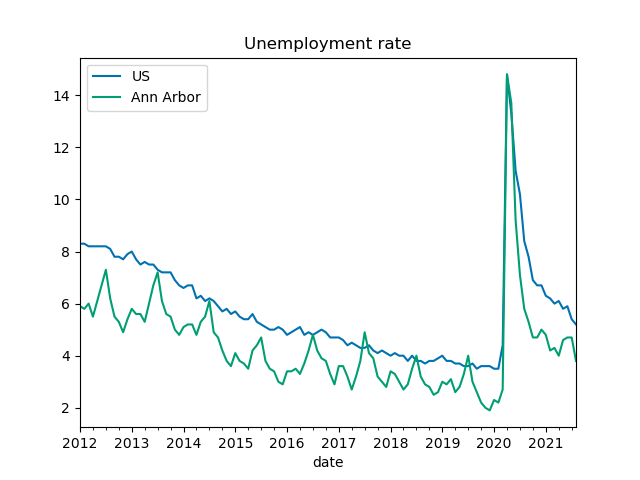

Text(0.5, 1.0, 'Unemployment rate')

In [39]:
df.plot()
plt.title('Unemployment rate')

<IPython.core.display.Javascript object>


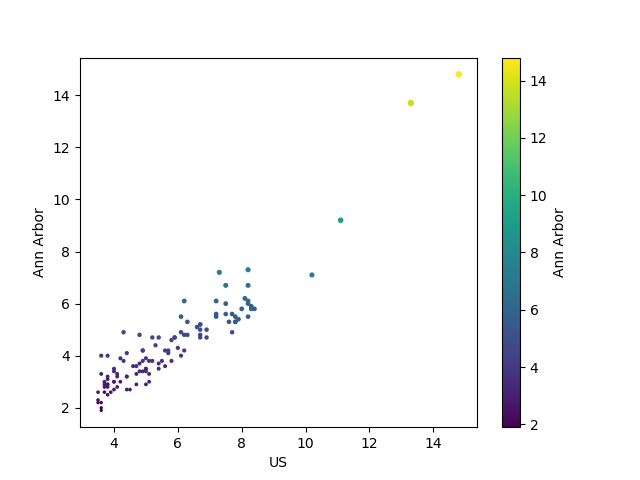

<AxesSubplot:xlabel='US', ylabel='Ann Arbor'>

In [32]:
df.plot.scatter('US', 'Ann Arbor', c='Ann Arbor', s=df['Ann Arbor'], colormap='viridis')

<IPython.core.display.Javascript object>


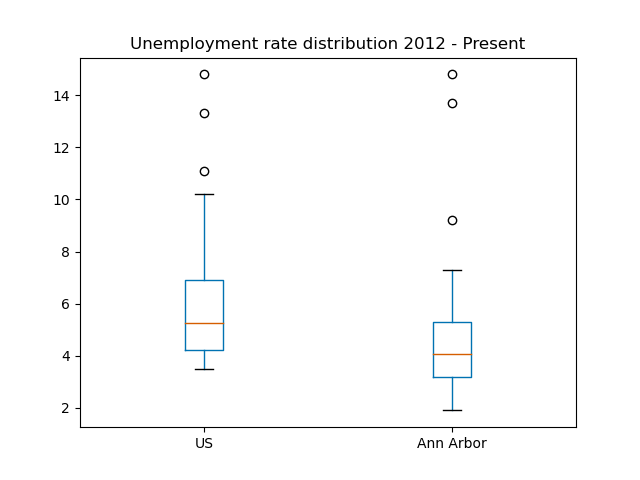

Text(0.5, 1.0, 'Unemployment rate distribution 2012 - Present')

In [41]:
df.plot.box();
plt.title('Unemployment rate distribution 2012 - Present')

<IPython.core.display.Javascript object>


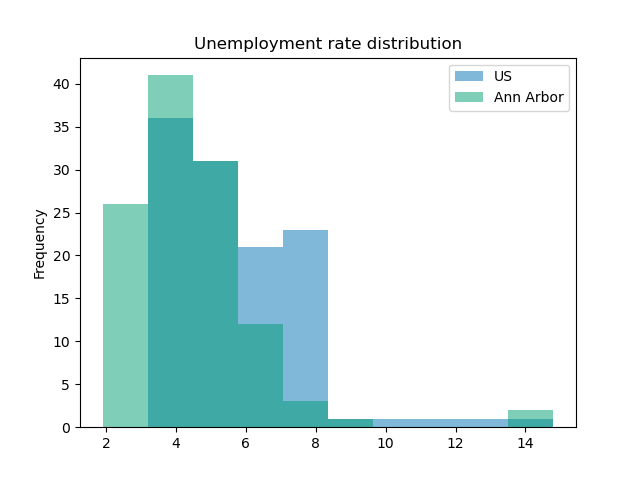

Text(0.5, 1.0, 'Unemployment rate distribution')

In [37]:
df.plot.hist(alpha=0.5);
plt.title('Unemployment rate distribution')

<IPython.core.display.Javascript object>


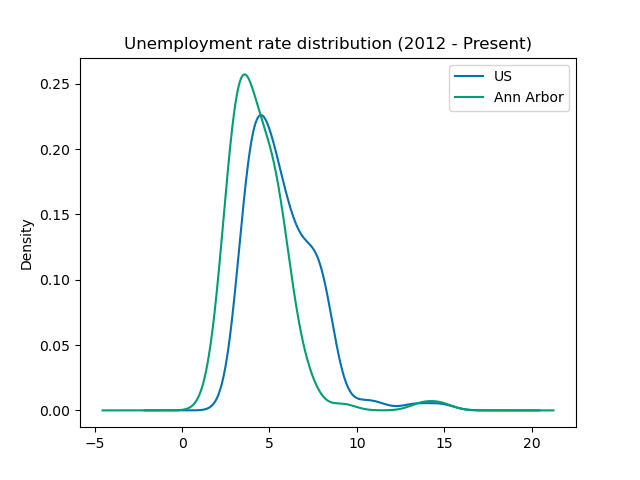

Text(0.5, 1.0, 'Unemployment rate distribution (2012 - Present)')

In [40]:
df.plot.kde();
plt.title('Unemployment rate distribution (2012 - Present)')
